In [51]:
import os
import cv2
import glob
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import face_recognition
from torch import nn

In [52]:
# Loading OpenCV DNN model for face extraction
dnn_model = "./deploy.prototxt"
dnn_weights = "./res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNetFromCaffe(dnn_model, dnn_weights)

In [54]:
def detect_faces_with_dnn(frame):
    """Detect faces using OpenCV's DNN module."""
    h, w = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    faces = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:  # Confidence threshold for face detection
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            faces.append((startY, endX, endY, startX))

    for i in range(detections.shape[2]):
        if not faces:
            faces.append(0, 300, 0, 300)
    return faces

In [55]:
# Set paths
DATA_FOLDER = './Testing_sorted'
REAL_FILE = './Testing_sorted/realVideos.txt'
FAKE_FILE = './Testing_sorted/fakeVideos.txt'
FEATURE_SAVE_PATH = './transformed_features/'
VAL_DATA_FOLDER = './Validation_sorted'
VAL_REAL_FILE = './Validation_sorted/realVideos.txt'
VAL_FAKE_FILE = './Validation_sorted/fakeVideos.txt'

# Ensure feature save path exists
os.makedirs(FEATURE_SAVE_PATH, exist_ok=True)

In [56]:
# Load video file paths and labels
def load_data():
    with open(REAL_FILE, 'r') as real_f:
        real_videos = [line.strip() for line in real_f.readlines()]
    with open(FAKE_FILE, 'r') as fake_f:
        fake_videos = [line.strip() for line in fake_f.readlines()]
    with open(VAL_REAL_FILE, 'r') as val_real_f:
        val_real_videos = [line.strip() for line in val_real_f.readlines()]
    with open(VAL_FAKE_FILE, 'r') as val_fake_f:
        val_fake_videos = [line.strip() for line in val_fake_f.readlines()]

    all_videos_set_1 = real_videos + fake_videos
    labels_set1 = [1] * len(real_videos) + [0] * len(fake_videos)
    all_videos_set2 = val_real_videos + val_fake_videos
    labels_set2 = [1] * len(val_real_videos) + [0] * len(val_fake_videos)
    labels = labels_set1 + labels_set2
    video_paths = [os.path.join(DATA_FOLDER, video) for video in all_videos_set_1] + [os.path.join(VAL_DATA_FOLDER, video) for video in all_videos_set2]

    # Shuffle and split into train (60%), val (20%), test (20%)
    combined = list(zip(video_paths, labels))
    random.shuffle(combined)
    video_paths, labels = zip(*combined)

    train_idx = int(0.6 * len(video_paths))
    val_idx = int(0.8 * len(video_paths))

    train_data = (video_paths[:train_idx], labels[:train_idx])
    val_data = (video_paths[train_idx:val_idx], labels[train_idx:val_idx])
    test_data = (video_paths[val_idx:], labels[val_idx:])
    
    return train_data, val_data, test_data


In [57]:

# Preprocessing: Detect faces, transform, and save features
import torch.nn.functional as F

def preprocess_and_save(video_paths, labels, transform, sequence_length, save_path):
    os.makedirs(save_path, exist_ok=True)
    for idx, video_path in tqdm(enumerate(video_paths), total=len(video_paths)):
        label = labels[idx]
        feature_path = os.path.join(save_path, os.path.basename(video_path) + '.pt')

        # Skip if already processed
        if os.path.exists(feature_path):
            continue

        # Extract faces and transform
        vidObj = cv2.VideoCapture(video_path)
        frames = []
        count = 0
        while count < sequence_length:
            success, frame = vidObj.read()
            if not success:
                break

            # Convert to RGB as DNN expects RGB input
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Detect face locations
            face_locations = detect_faces_with_dnn(rgb_frame)

            if face_locations:
                # Crop the first detected face
                top, right, bottom, left = face_locations[0]
                face = rgb_frame[top:bottom, left:right]

                # Resize and transform the face
                face = cv2.resize(face, (im_size, im_size))
                face = transform(face)
                frames.append(face)
                count += 1

        vidObj.release()

        # Skip videos where no faces were detected
        if len(frames) == 0:
            print(f"Skipping video (no faces detected): {video_path}")
            continue

        # Pad the sequence if fewer frames were detected
        if len(frames) < sequence_length:
            pad_size = sequence_length - len(frames)
            padding = [torch.zeros_like(frames[0]) for _ in range(pad_size)]
            frames.extend(padding)

        # Stack the frames and save
        frames = torch.stack(frames[:sequence_length])
        torch.save((frames, label), feature_path)



In [58]:

# Dataset class for loading preprocessed features
class PreprocessedDataset(Dataset):
    def __init__(self, feature_dir):
        self.feature_dir = feature_dir
        self.files = [
            os.path.join(feature_dir, f)
            for f in os.listdir(feature_dir) if f.endswith('.pt')
        ]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        feature_path = self.files[idx]

        # Load preprocessed features and label
        frames, label = torch.load(feature_path, weights_only=False)
        return frames, label



In [59]:

# Transformations
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:

class Model(nn.Module):
    def __init__(self, num_classes=2, latent_dim=512, lstm_layers=1, hidden_dim=512):
        super(Model, self).__init__()
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=False)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.feature_extractor(x)
        x = self.avgpool(fmap).view(batch_size, seq_length, -1)
        x, _ = self.lstm(x)
        x = self.fc(x.mean(dim=1))
        return fmap, x

In [61]:
train_dataset = PreprocessedDataset(feature_dir='./transformed_features/train')
val_dataset = PreprocessedDataset(feature_dir='./transformed_features/val')
test_dataset = PreprocessedDataset(feature_dir='./transformed_features/test')

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)


In [ ]:
def evaluate_model_with_metrics(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    all_preds = []
    all_targets = []
    total_loss = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            _, outputs = model(inputs)
            total_loss += criterion(outputs, targets).item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = (np.array(all_preds) == np.array(all_targets)).mean() * 100
    cm = confusion_matrix(all_targets, all_preds)

    return avg_loss, accuracy, cm

In [64]:
# Training with Early Stopping
def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-5, patience=5):
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.cuda()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], [] 

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        model.train() 
        running_loss = 0.0 
        correct_preds = 0 
        total_preds = 0 

        for inputs, targets in train_loader: 
            inputs, targets = inputs.cuda(), targets.cuda() 
            _, outputs = model(inputs)             
            loss = criterion(outputs, targets) 
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == targets).item()
            total_preds += targets.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds / total_preds
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        val_loss, val_accuracy, _ = evaluate_model_with_metrics(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy / 100)

        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # check for improvement validation 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the best model's state
            patience_counter = 0  # reset patience counter
        else:
            patience_counter += 1
            print(f"Early stopping patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses


In [ ]:
# Final test evaluation
def test_model(model, test_loader):
    print("\nEvaluating on test set:")
    test_loss, test_accuracy, cm = evaluate_model_with_metrics(model, test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print("Confusion Matrix:")
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"]).plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

## Hyperparameter tuning:

Epoch 1/20
Train Loss: 0.6841, Train Accuracy: 0.5500
Val Loss: 0.6797, Val Accuracy: 56.91%
Epoch 2/20
Train Loss: 0.6702, Train Accuracy: 0.6029
Val Loss: 0.6510, Val Accuracy: 65.04%
Epoch 3/20
Train Loss: 0.6364, Train Accuracy: 0.6794
Val Loss: 0.6105, Val Accuracy: 68.29%
Epoch 4/20
Train Loss: 0.5915, Train Accuracy: 0.7235
Val Loss: 0.5216, Val Accuracy: 73.98%
Epoch 5/20
Train Loss: 0.4920, Train Accuracy: 0.8265
Val Loss: 0.4746, Val Accuracy: 79.67%
Epoch 6/20
Train Loss: 0.4361, Train Accuracy: 0.8176
Val Loss: 0.4633, Val Accuracy: 83.74%
Epoch 7/20
Train Loss: 0.3717, Train Accuracy: 0.8382
Val Loss: 0.4449, Val Accuracy: 83.74%
Epoch 8/20
Train Loss: 0.3707, Train Accuracy: 0.8265
Val Loss: 0.3928, Val Accuracy: 87.80%
Epoch 9/20
Train Loss: 0.3334, Train Accuracy: 0.8500
Val Loss: 0.3569, Val Accuracy: 82.93%
Epoch 10/20
Train Loss: 0.2843, Train Accuracy: 0.9088
Val Loss: 0.4053, Val Accuracy: 86.18%
Early stopping patience: 1/5
Epoch 11/20
Train Loss: 0.2747, Train Ac

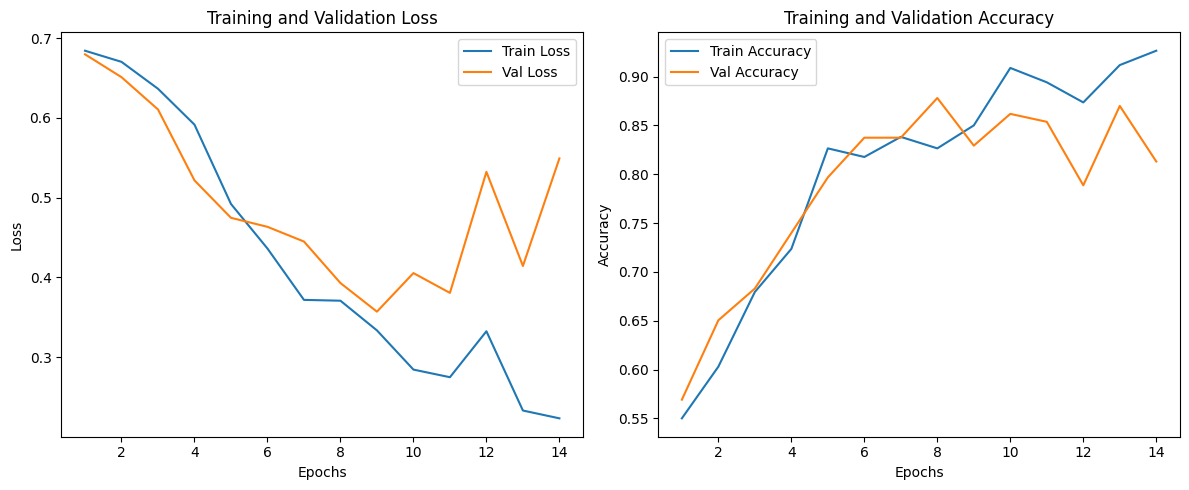

In [66]:
model_1 = Model()
train_losses, val_losses = train_model(model_1, train_loader, val_loader)

Epoch 1/20
Train Loss: 0.6907, Train Accuracy: 0.5412
Val Loss: 0.6959, Val Accuracy: 47.97%
Epoch 2/20
Train Loss: 0.6905, Train Accuracy: 0.5412
Val Loss: 0.6962, Val Accuracy: 47.97%
Early stopping patience: 1/5
Epoch 3/20
Train Loss: 0.6906, Train Accuracy: 0.5412
Val Loss: 0.6964, Val Accuracy: 47.97%
Early stopping patience: 2/5
Epoch 4/20
Train Loss: 0.6903, Train Accuracy: 0.5412
Val Loss: 0.6965, Val Accuracy: 47.97%
Early stopping patience: 3/5
Epoch 5/20
Train Loss: 0.6903, Train Accuracy: 0.5412
Val Loss: 0.6967, Val Accuracy: 47.97%
Early stopping patience: 4/5
Epoch 6/20
Train Loss: 0.6904, Train Accuracy: 0.5412
Val Loss: 0.6968, Val Accuracy: 47.97%
Early stopping patience: 5/5
Early stopping triggered. Stopping training.


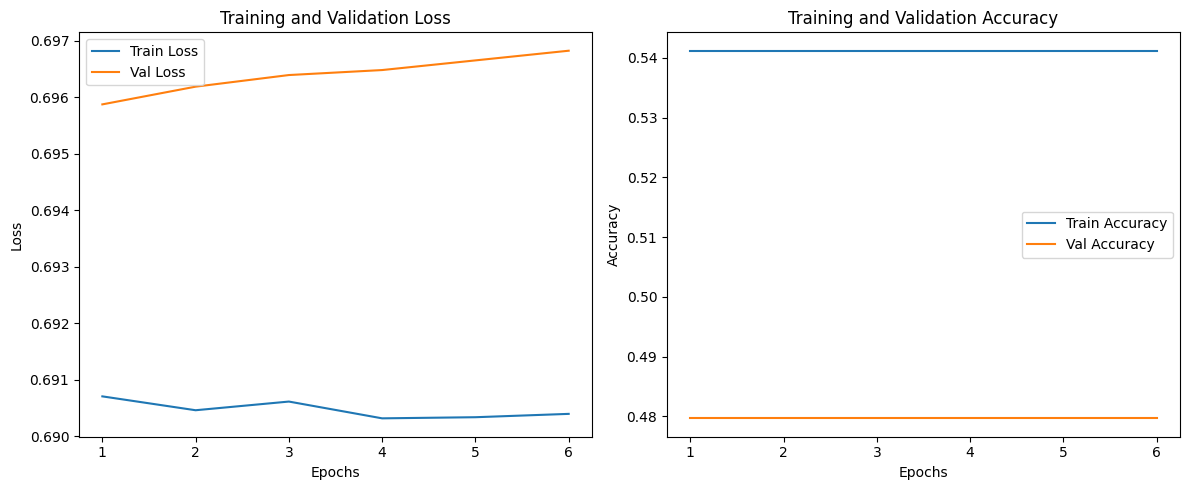

In [67]:
model_2 = Model(lstm_layers=10)
train_losses, val_losses = train_model(model_2, train_loader, val_loader)

Epoch 1/20
Train Loss: 0.6918, Train Accuracy: 0.5412
Val Loss: 0.6944, Val Accuracy: 47.97%
Epoch 2/20
Train Loss: 0.6916, Train Accuracy: 0.5412
Val Loss: 0.6945, Val Accuracy: 47.97%
Early stopping patience: 1/5
Epoch 3/20
Train Loss: 0.6913, Train Accuracy: 0.5412
Val Loss: 0.6950, Val Accuracy: 47.97%
Early stopping patience: 2/5
Epoch 4/20
Train Loss: 0.6913, Train Accuracy: 0.5412
Val Loss: 0.6951, Val Accuracy: 47.97%
Early stopping patience: 3/5
Epoch 5/20
Train Loss: 0.6905, Train Accuracy: 0.5412
Val Loss: 0.6955, Val Accuracy: 47.97%
Early stopping patience: 4/5
Epoch 6/20
Train Loss: 0.6905, Train Accuracy: 0.5412
Val Loss: 0.6962, Val Accuracy: 47.97%
Early stopping patience: 5/5
Early stopping triggered. Stopping training.


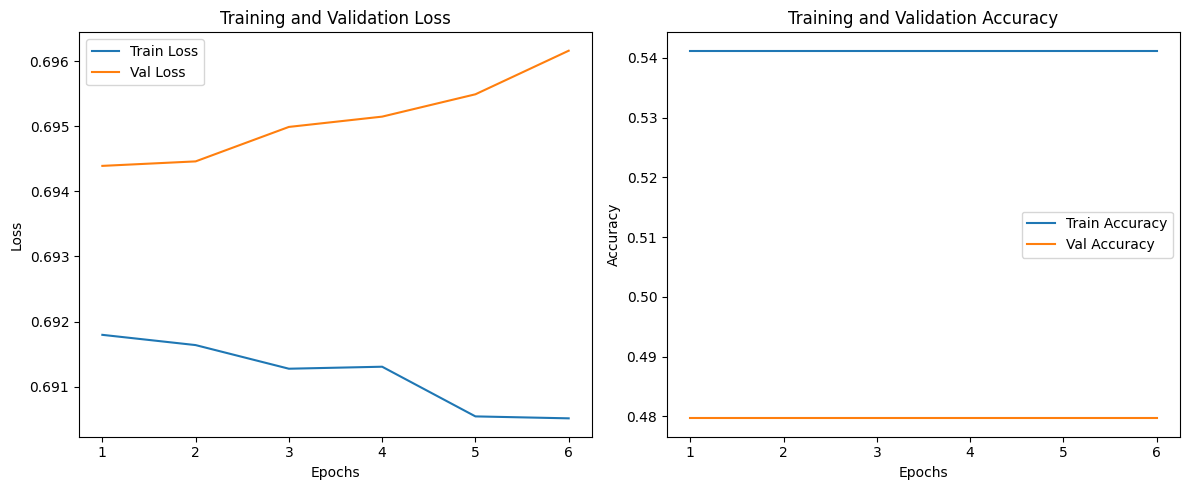

In [68]:
model_2 = Model(lstm_layers=5)
train_losses, val_losses = train_model(model_2, train_loader, val_loader)

## Final Model

Epoch 1/20
Train Loss: 0.6896, Train Accuracy: 0.5471
Val Loss: 0.6747, Val Accuracy: 59.35%
Epoch 2/20
Train Loss: 0.6690, Train Accuracy: 0.5735
Val Loss: 0.6453, Val Accuracy: 65.04%
Epoch 3/20
Train Loss: 0.6359, Train Accuracy: 0.6971
Val Loss: 0.5924, Val Accuracy: 73.17%
Epoch 4/20
Train Loss: 0.5621, Train Accuracy: 0.7441
Val Loss: 0.5338, Val Accuracy: 73.98%
Epoch 5/20
Train Loss: 0.4909, Train Accuracy: 0.7824
Val Loss: 0.4201, Val Accuracy: 82.93%
Epoch 6/20
Train Loss: 0.4411, Train Accuracy: 0.8265
Val Loss: 0.4033, Val Accuracy: 81.30%
Epoch 7/20
Train Loss: 0.3508, Train Accuracy: 0.8706
Val Loss: 0.4208, Val Accuracy: 82.93%
Early stopping patience: 1/5
Epoch 8/20
Train Loss: 0.3653, Train Accuracy: 0.8324
Val Loss: 0.3659, Val Accuracy: 85.37%
Epoch 9/20
Train Loss: 0.2535, Train Accuracy: 0.9088
Val Loss: 0.3263, Val Accuracy: 89.43%
Epoch 10/20
Train Loss: 0.2992, Train Accuracy: 0.8588
Val Loss: 0.3172, Val Accuracy: 85.37%
Epoch 11/20
Train Loss: 0.3426, Train Ac

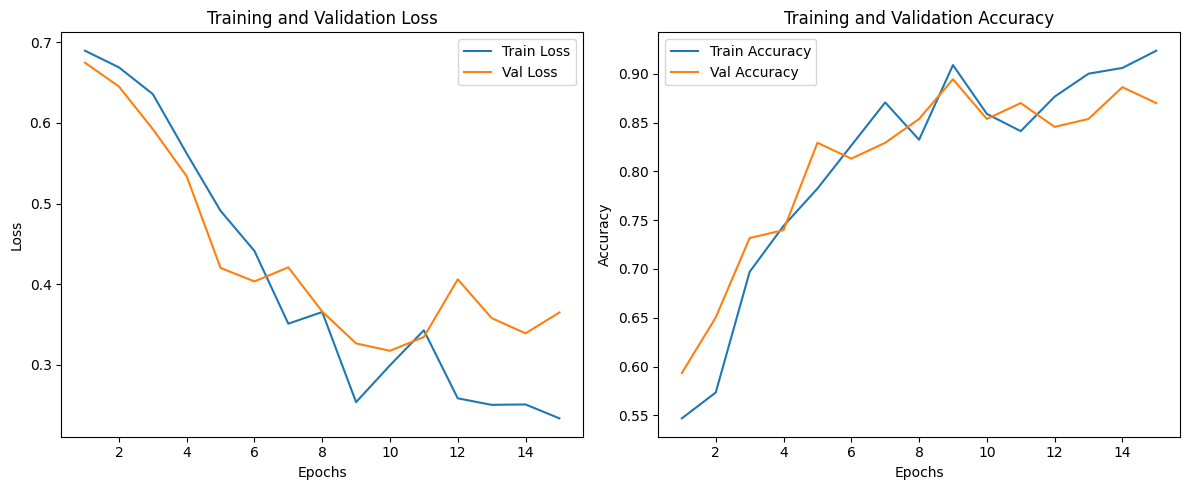


Evaluating on test set:
Test Loss: 0.2502, Test Accuracy: 89.47%
Confusion Matrix:


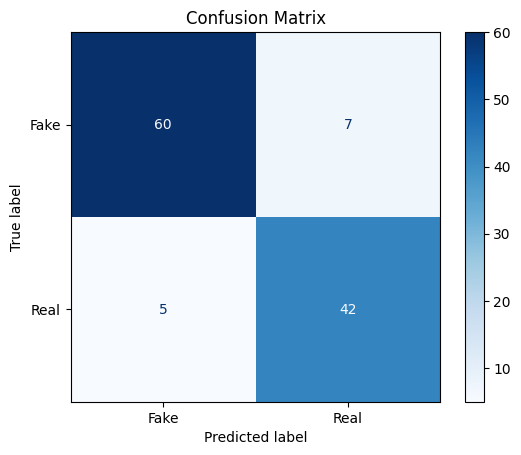

In [69]:
model = Model()
train_losses, val_losses = train_model(model, train_loader, val_loader)
test_model(model, test_loader)
